**Purpose**: Extends the custom embedding model with regularization
- Adds L2 regularization to control embedding magnitudes
- Compares regularized vs non-regularized embeddings
- Shows how regularization affects similarity rankings
- Includes visualization of regularization effects
- Demonstrates more stable similarity scores

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Step 1: Prepare the Dataset
sentences = [
    "The cat sits on the mat.",
    "A dog barks at the mailman.",
    "Birds are flying in the sky.",
    "The fish swims in the aquarium.",
    "A horse runs across the field.",
    "The lion roars in the jungle.",
    "She reads a book by the window."
]
labels = [0, 1, 2, 3, 4, 5, 6]

# Step 2: Create a Vocabulary and Encode Sentences
all_text = ' '.join(sentences)
word_counts = Counter(all_text.lower().split())
vocab = {word: idx+1 for idx, (word, _) in enumerate(word_counts.items())}  # Start from 1
vocab_size = len(vocab) + 1  # Plus one for padding index 0

def encode_sentence(sentence, vocab):
    return [vocab[word] for word in sentence.lower().split()]

encoded_sentences = [encode_sentence(s, vocab) for s in sentences]

# Step 3: Create a Custom Dataset
class TextDataset(Dataset):
    def __init__(self, encoded_sentences, labels):
        self.encoded_sentences = [torch.tensor(s, dtype=torch.long) for s in encoded_sentences]
        self.labels = labels

    def __len__(self):
        return len(self.encoded_sentences)

    def __getitem__(self, idx):
        return self.encoded_sentences[idx], self.labels[idx]

dataset = TextDataset(encoded_sentences, labels)

# Step 4: Define a Custom Collate Function
def collate_fn(batch):
    inputs = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Pad the sequences
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)

    # Convert targets to tensor
    targets_tensor = torch.tensor(targets, dtype=torch.long)

    return inputs_padded, targets_tensor

# Step 5: DataLoader with Custom Collate Function
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Step 6: Define the Embedding Model
class SimpleEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SimpleEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

    def forward(self, x):
        # x shape: [batch_size, seq_length]
        embedded = self.embedding(x)  # [batch_size, seq_length, embedding_dim]

        # Create a mask to ignore padding indices
        mask = (x != 0).unsqueeze(-1).float()  # [batch_size, seq_length, 1]

        # Apply mask to embeddings
        masked_embedded = embedded * mask

        # Compute the sum of embeddings and divide by the number of valid tokens
        summed = masked_embedded.sum(dim=1)  # [batch_size, embedding_dim]
        lengths = mask.sum(dim=1)  # [batch_size, 1]

        # Avoid division by zero
        lengths[lengths == 0] = 1

        averaged = summed / lengths  # [batch_size, embedding_dim]

        return averaged

# Function to train the model with optional regularization
def train_model(apply_regularization=False, weight_decay=0.0):
    # Step 7: Training Parameters
    embedding_dim = 50
    num_epochs = 20
    learning_rate = 0.01

    # Step 8: Initialize Model, Loss Function, Optimizer
    model = SimpleEmbeddingModel(vocab_size, embedding_dim)
    criterion = nn.CrossEntropyLoss()

    # Apply weight decay (L2 regularization) if specified
    if apply_regularization:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Step 9: Training Loop
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Step 10: Extract Embeddings
    model.eval()
    with torch.no_grad():
        sentence_embeddings = []
        for idx in range(len(sentences)):
            input_tensor = torch.tensor(encoded_sentences[idx], dtype=torch.long).unsqueeze(0)
            embedding = model(input_tensor)
            sentence_embeddings.append(embedding.numpy()[0])
    sentence_embeddings = np.array(sentence_embeddings)

    return sentence_embeddings

# Function to perform scaling and compute cosine similarities
# def analyze_embeddings(sentence_embeddings):
#     # Step 11: Compute Original Cosine Similarities
#     original_cosine_similarities = cosine_similarity(sentence_embeddings)

#     # Step 12: Introduce Scaling into Embeddings
#     embedding_dim = sentence_embeddings.shape[1]
#     scaling_factors = np.ones(embedding_dim)
#     scaling_factors[:embedding_dim // 2] = 0.01
#     scaling_factors[embedding_dim // 2:] = 100

#     scaled_embeddings = sentence_embeddings * scaling_factors

#     # Step 13: Compute Scaled Cosine Similarities
#     scaled_cosine_similarities = cosine_similarity(scaled_embeddings)

#     return original_cosine_similarities, scaled_cosine_similarities

def analyze_embeddings(sentence_embeddings):
    # Normalize embeddings before scaling
    sentence_embeddings = sentence_embeddings / np.linalg.norm(sentence_embeddings, axis=1, keepdims=True)

    # Compute original cosine similarities
    original_cosine_similarities = cosine_similarity(sentence_embeddings)

    # Introduce scaling into embeddings
    embedding_dim = sentence_embeddings.shape[1]
    scaling_factors = np.ones(embedding_dim)
    scaling_factors[:embedding_dim // 2] = 0.01
    scaling_factors[embedding_dim // 2:] = 100

    scaled_embeddings = sentence_embeddings * scaling_factors

    # Normalize scaled embeddings
    scaled_embeddings = scaled_embeddings / np.linalg.norm(scaled_embeddings, axis=1, keepdims=True)

    # Compute scaled cosine similarities
    scaled_cosine_similarities = cosine_similarity(scaled_embeddings)

    return original_cosine_similarities, scaled_cosine_similarities

# Function to visualize and compare similarities
def compare_similarities(original_cosine_similarities, scaled_cosine_similarities, title_suffix=''):
    # Step 14: Visualize Cosine Similarities
    def plot_similarity_matrix(similarity_matrix, title):
        plt.figure(figsize=(8, 6))
        sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt=".2f",
                    xticklabels=sentences, yticklabels=sentences)
        plt.title(title)
        plt.show()

    plot_similarity_matrix(original_cosine_similarities, f"Original Cosine Similarities {title_suffix}")
    plot_similarity_matrix(scaled_cosine_similarities, f"Scaled Cosine Similarities {title_suffix}")

    # Step 15: Observe Changes in Rankings
    for idx, sentence in enumerate(sentences):
        print(f"Sentence: '{sentence}'{title_suffix}")
        
        original_scores = original_cosine_similarities[idx]
        original_rankings = np.argsort(-original_scores)
        print("Top similar sentences (original):")
        for i in original_rankings[1:3]:
            print(f"  '{sentences[i]}' with score {original_scores[i]:.4f}")
        
        scaled_scores = scaled_cosine_similarities[idx]
        scaled_rankings = np.argsort(-scaled_scores)
        print("Top similar sentences (scaled):")
        for i in scaled_rankings[1:3]:
            print(f"  '{sentences[i]}' with score {scaled_scores[i]:.4f}")
        
        print("-" * 60)

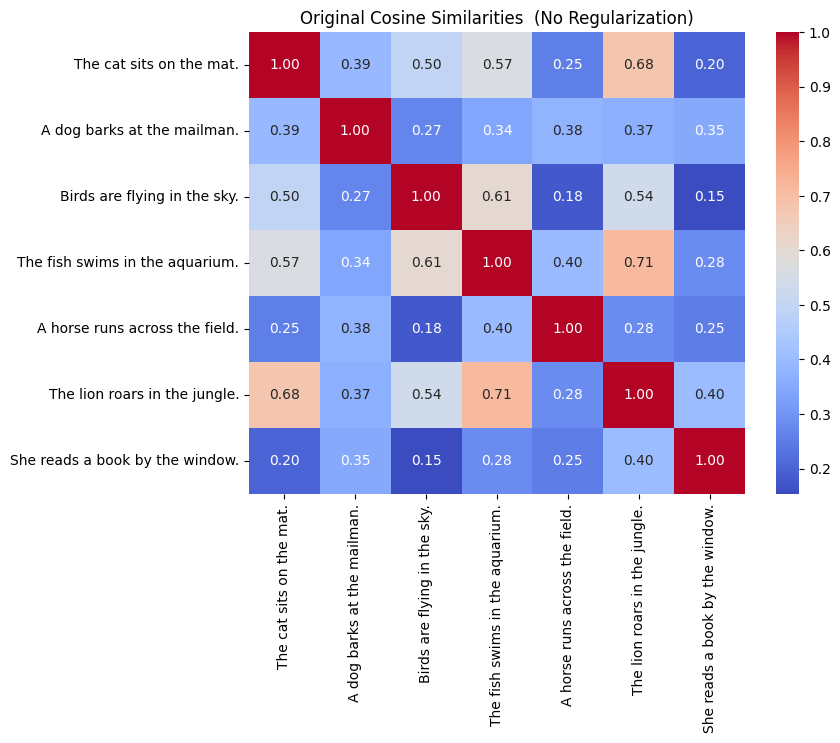

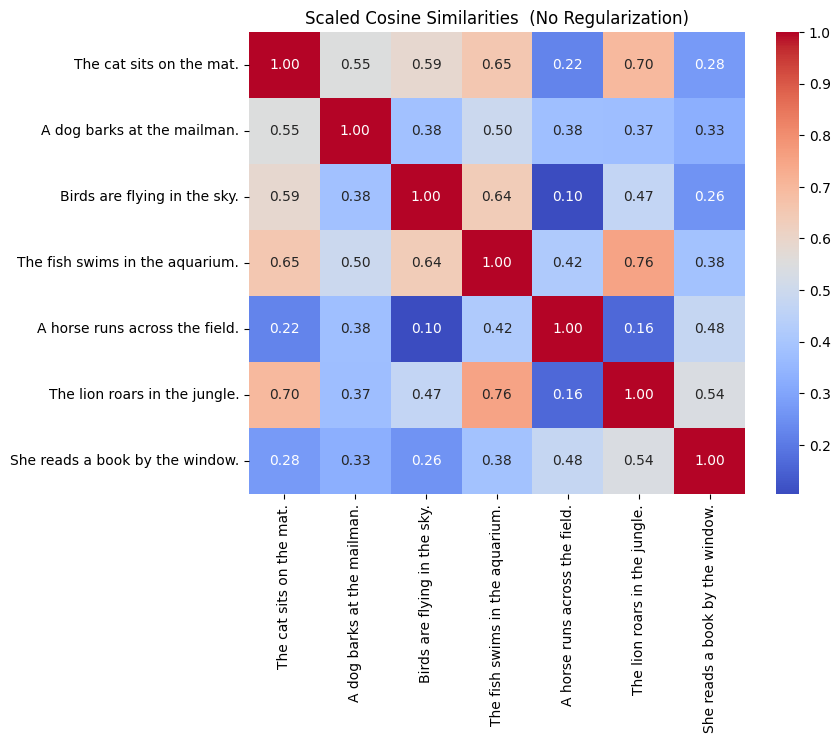

Sentence: 'The cat sits on the mat.' (No Regularization)
Top similar sentences (original):
  'The lion roars in the jungle.' with score 0.6785
  'The fish swims in the aquarium.' with score 0.5658
Top similar sentences (scaled):
  'The lion roars in the jungle.' with score 0.6959
  'The fish swims in the aquarium.' with score 0.6546
------------------------------------------------------------
Sentence: 'A dog barks at the mailman.' (No Regularization)
Top similar sentences (original):
  'The cat sits on the mat.' with score 0.3947
  'A horse runs across the field.' with score 0.3779
Top similar sentences (scaled):
  'The cat sits on the mat.' with score 0.5506
  'The fish swims in the aquarium.' with score 0.4954
------------------------------------------------------------
Sentence: 'Birds are flying in the sky.' (No Regularization)
Top similar sentences (original):
  'The fish swims in the aquarium.' with score 0.6061
  'The lion roars in the jungle.' with score 0.5361
Top similar sen

In [3]:
# Train model without regularization
embeddings_no_reg = train_model(apply_regularization=False)

# Analyze embeddings
original_sim_no_reg, scaled_sim_no_reg = analyze_embeddings(embeddings_no_reg)

# Compare similarities
compare_similarities(original_sim_no_reg, scaled_sim_no_reg, title_suffix=' (No Regularization)')

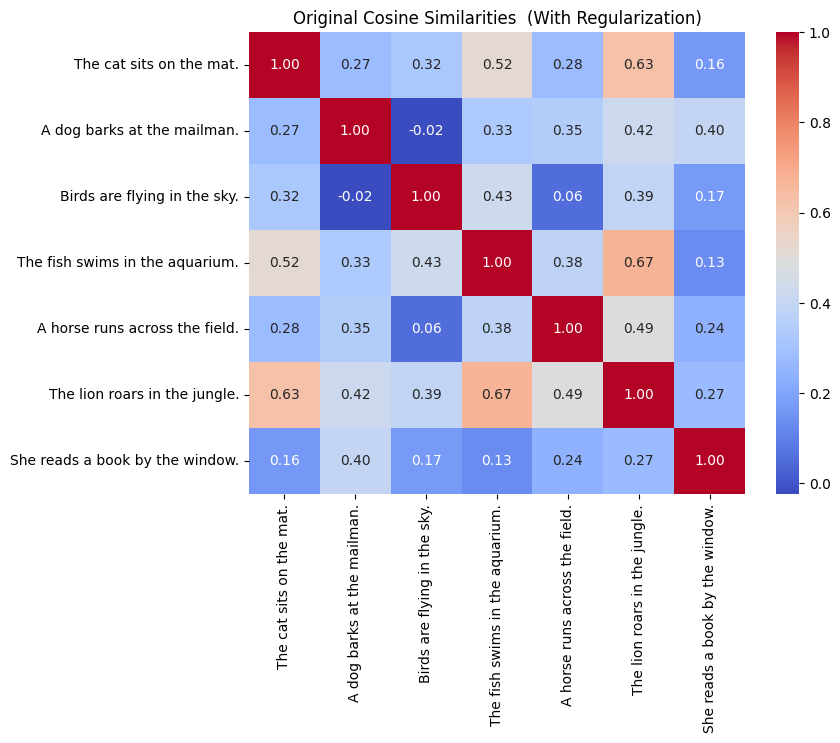

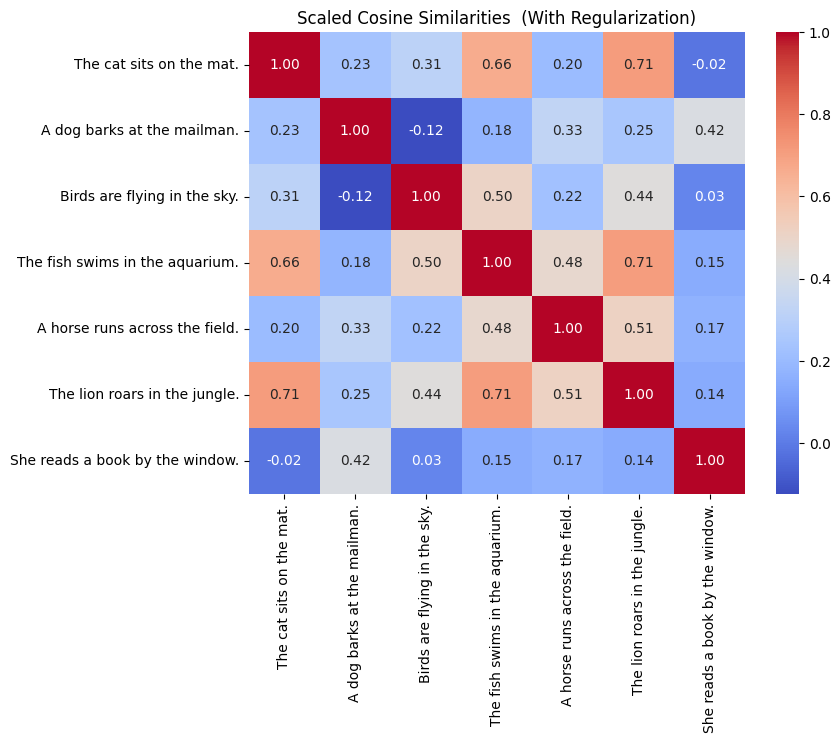

Sentence: 'The cat sits on the mat.' (With Regularization)
Top similar sentences (original):
  'The lion roars in the jungle.' with score 0.6264
  'The fish swims in the aquarium.' with score 0.5196
Top similar sentences (scaled):
  'The lion roars in the jungle.' with score 0.7118
  'The fish swims in the aquarium.' with score 0.6631
------------------------------------------------------------
Sentence: 'A dog barks at the mailman.' (With Regularization)
Top similar sentences (original):
  'The lion roars in the jungle.' with score 0.4221
  'She reads a book by the window.' with score 0.3994
Top similar sentences (scaled):
  'She reads a book by the window.' with score 0.4209
  'A horse runs across the field.' with score 0.3296
------------------------------------------------------------
Sentence: 'Birds are flying in the sky.' (With Regularization)
Top similar sentences (original):
  'The fish swims in the aquarium.' with score 0.4321
  'The lion roars in the jungle.' with score 0.39

In [4]:
# Train model with regularization
embeddings_with_reg = train_model(apply_regularization=True, weight_decay=0.01)

# Analyze embeddings
original_sim_with_reg, scaled_sim_with_reg = analyze_embeddings(embeddings_with_reg)

# Compare similarities
compare_similarities(original_sim_with_reg, scaled_sim_with_reg, title_suffix=' (With Regularization)')